# Correlation Matrix with Pytorch

In [1]:
%load_ext autoreload

In [2]:
import sys
sys.path.append('/home/labic/merlin_codes/dl/Parkinson-Diagnosis-Deeplearning')

import os
import time

import parkinson

import torch
from torch import nn

import pandas as pd
import networkx as nx
import numpy as np

from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [3]:
RDN = 50
N_CLASSES = 2
BATCH_SIZE = 32
N_EPOCHS = 200
PATIENCE = 20
LR = 0.0001

## Data Processing
### Reading

In [4]:
from imblearn.over_sampling import RandomOverSampler

parkinson_data = parkinson.utils.data.batch_read('../data/PDs_columns')
control_data = parkinson.utils.data.batch_read('../data/Controls_columns')

control_atlas_data = parkinson.utils.data.select_atlas_columns(control_data, 'AAL3')
parkinson_atlas_data = parkinson.utils.data.select_atlas_columns(parkinson_data, 'AAL3')

parkinson_correlation_matrix = [parkinson.utils.graph.compute_correlation_matrix(time_series) for time_series in parkinson_atlas_data]
control_correlation_matrix = [parkinson.utils.graph.compute_correlation_matrix(time_series) for time_series in control_atlas_data]

X = parkinson.utils.data.concatenate_data(parkinson_correlation_matrix, control_correlation_matrix)
y = parkinson.utils.data.concatenate_data([1 for _ in range(len(parkinson_data))], [0 for _ in range(len(control_data))])

X, y = parkinson.utils.data.filter_data(X, y)

ros = RandomOverSampler(random_state=RDN)
X_res, y_res = ros.fit_resample(X, y)

X = X_res
y = y_res

100%|██████████| 66/66 [00:01<00:00, 42.20it/s]


### Split  
- 60% treino
- 20% validação
- 20% teste

In [5]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=RDN, stratify=y, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=RDN, stratify=y_trainval, shuffle=True)

### Dataloaders

In [6]:
train_loader = parkinson.utils.data.get_torch_dataloader(X_train, y_train, batch_size=BATCH_SIZE)
val_loader = parkinson.utils.data.get_torch_dataloader(X_val, y_val, batch_size=BATCH_SIZE)
test_loader = parkinson.utils.data.get_torch_dataloader(X_test, y_test, batch_size=BATCH_SIZE)

## Training

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = parkinson.NetworkModels.SimpleMLP(input_dim=X_train.shape[1], hidden_dim=16, output_dim=2)
class_weights = parkinson.utils.data.get_torch_class_weights(y_train)

In [8]:
model.train()
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

In [9]:
%%time
out = parkinson.utils.train.train(model, train_loader, val_loader, class_weights, device, N_EPOCHS,  PATIENCE,LR)

train-loss: 0.1395  train-acc: 1.0000 | val-loss: 0.4086  val-acc: 0.8033:  55%|█████▍    | 109/200 [00:36<00:30,  2.99it/s]

Early stopping at epoch 110
CPU times: user 2.6 s, sys: 26.2 s, total: 28.8 s
Wall time: 37.2 s


In [10]:
metrics = parkinson.utils.train.evaluate(model, test_loader, device)
print('Metrics:', metrics)
print('Done.')

Preds: [0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1]
Metrics: {'acc': 0.8548387096774194, 'f1': 0.8544980443285529, 'recall': 0.8548387096774194, 'precision': 0.8581932773109244}
Done.


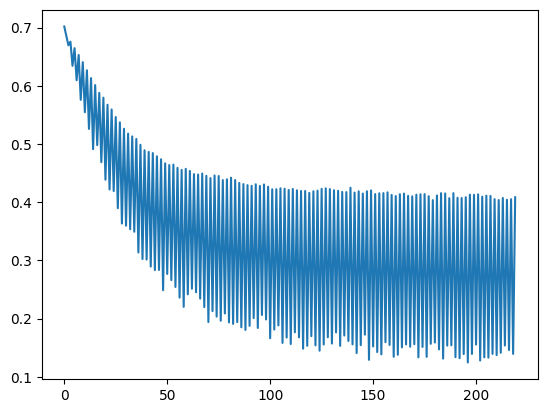

In [11]:
import matplotlib.pyplot as plt

val_loss =  out['val_loss']
plt.plot(np.arange(len(val_loss)), val_loss)